## Imports 

In [1]:
import time
start = time.time()
import itertools
import pandas as pd
import numpy as np
from calendar import month_name
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, plot_roc_curve, roc_curve

## Loading the data

In [2]:
X = pd.read_csv("feature_data.csv", index_col=0)
X_backup = X.copy()
y = pd.read_csv("label_data.csv", index_col=0)
X_test = pd.read_csv("feature_data_test.csv", index_col=0)

## Part 1: Data Exploration
Let's start by looking at our features and their types:

In [3]:
print("\n".join([f"{col}: {X[col].dtype}" for col in X.columns]))

time_until_order: float64
order_year: int64
order_month: object
order_week: object
order_day_of_month: int64
adults: int64
children: float64
babies: int64
country: object
order_type: object
acquisition_channel: object
prev_canceled: int64
prev_not_canceled: int64
changes: float64
deposit_type: object
agent: float64
company: float64
customer_type: object
adr: float64
anon_feat_0: float64
anon_feat_1: int64
anon_feat_2: int64
anon_feat_3: int64
anon_feat_4: int64
anon_feat_5: float64
anon_feat_6: float64
anon_feat_7: float64
anon_feat_8: int64
anon_feat_9: float64
anon_feat_10: float64
anon_feat_11: float64
anon_feat_12: bool
anon_feat_13: float64


We can see that anon_feat_12 is a boolean feature.
Let's convert it to a numerical feature so we can interact with it a bit more. <br/>

In [4]:
X[X["anon_feat_12"].isna()].shape

(0, 33)

It looks like there are no samples that have a null value for this variable - so we can convert the column safely.
We can also convert order_month and order_week to numerical form.

In [5]:
def initial_preprocess(X):
    X["anon_feat_12"] = [int(value) for value in X["anon_feat_12"]]

    months = list(month_name)
    months[0] = np.nan
    X["order_month"] = [months.index(value) for value in X["order_month"]]
    X["order_week"] = [int(week.replace("week_", "")) for week in X["order_week"]]

initial_preprocess(X)

Let's look at the distribution of different features in the data:

array([[<AxesSubplot:title={'center':'time_until_order'}>,
        <AxesSubplot:title={'center':'order_year'}>,
        <AxesSubplot:title={'center':'order_month'}>,
        <AxesSubplot:title={'center':'order_week'}>,
        <AxesSubplot:title={'center':'order_day_of_month'}>],
       [<AxesSubplot:title={'center':'adults'}>,
        <AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>,
        <AxesSubplot:title={'center':'prev_canceled'}>,
        <AxesSubplot:title={'center':'prev_not_canceled'}>],
       [<AxesSubplot:title={'center':'changes'}>,
        <AxesSubplot:title={'center':'agent'}>,
        <AxesSubplot:title={'center':'company'}>,
        <AxesSubplot:title={'center':'adr'}>,
        <AxesSubplot:title={'center':'anon_feat_0'}>],
       [<AxesSubplot:title={'center':'anon_feat_1'}>,
        <AxesSubplot:title={'center':'anon_feat_2'}>,
        <AxesSubplot:title={'center':'anon_feat_3'}>,
        <AxesSubplot:title={'center':'anon

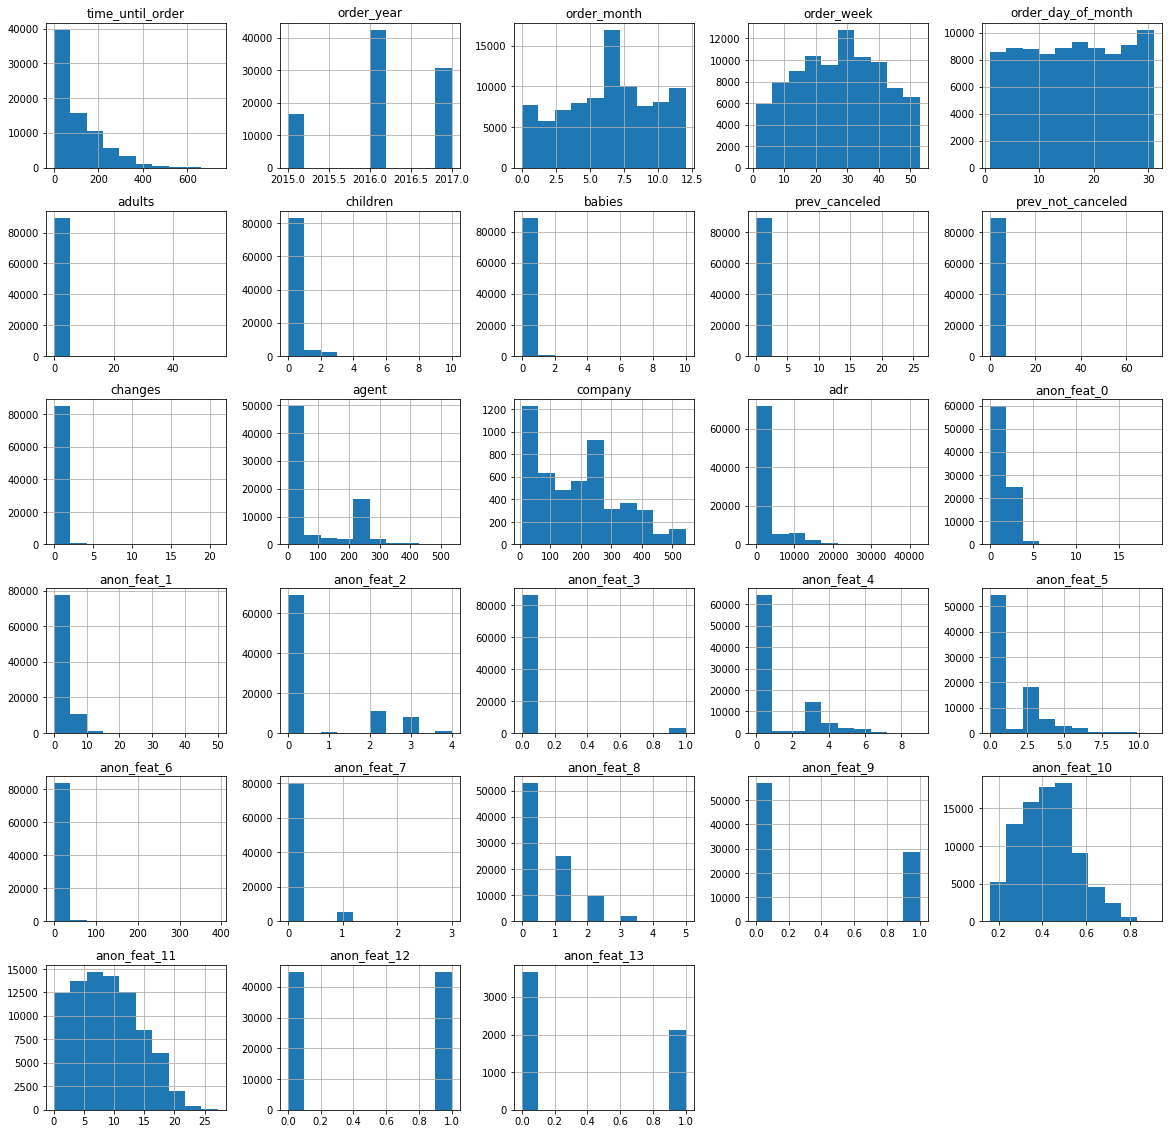

In [6]:
CATEGORICAL_FEATURES = [col_name for col_name in X.columns if X[col_name].dtype == np.object]
X.hist(figsize=(20,20))

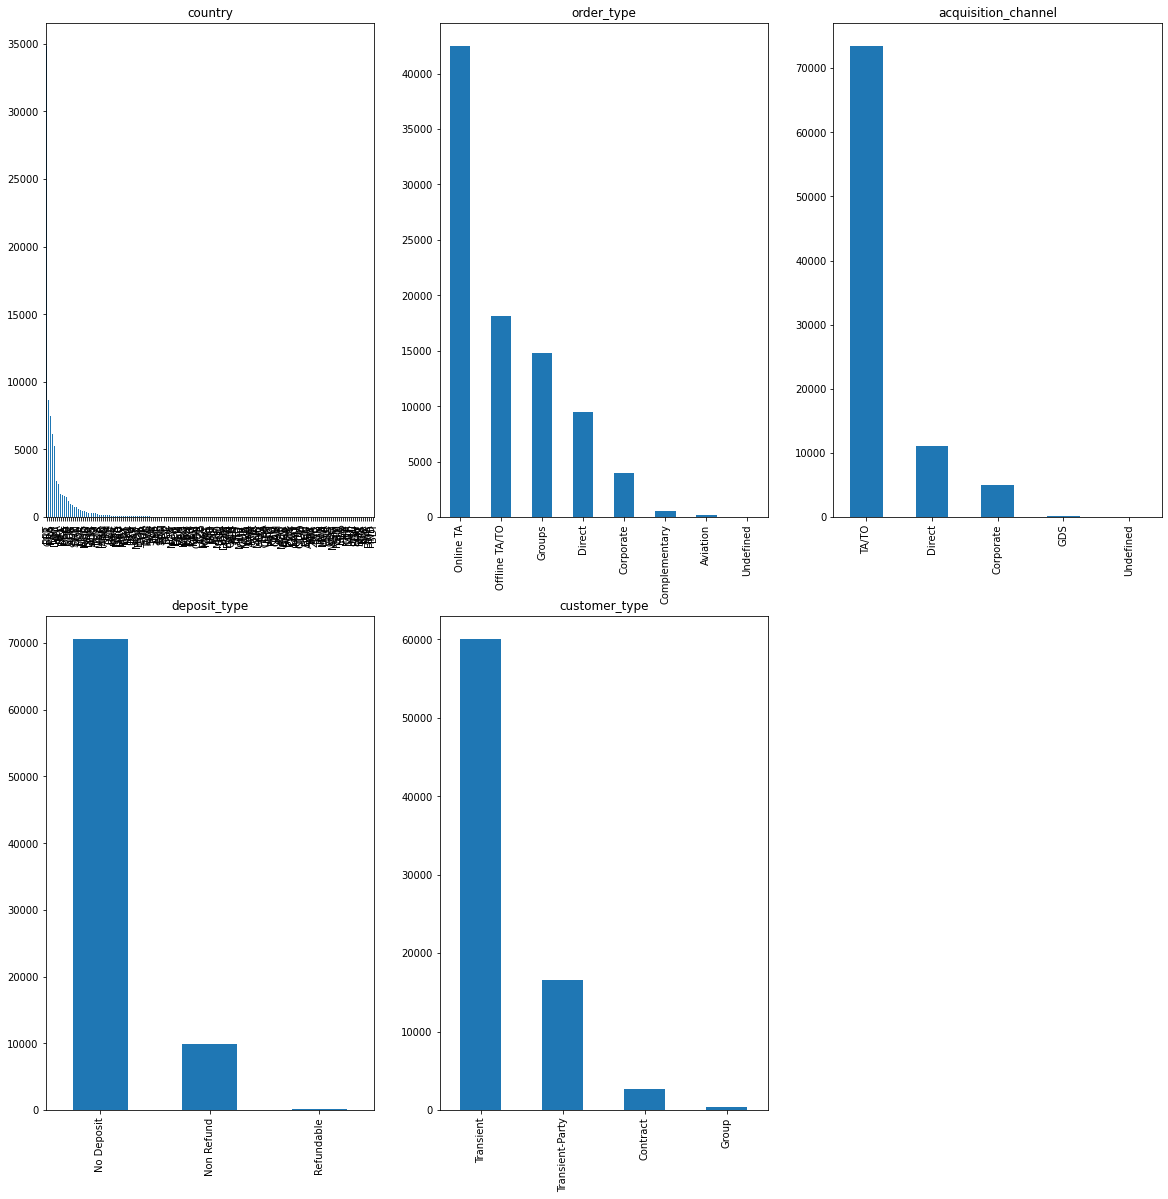

In [7]:
fig, axes = plt.subplots(2, 3)
for category in CATEGORICAL_FEATURES:
    index = CATEGORICAL_FEATURES.index(category)
    ax = axes[int(index / 3), index % 3]
    X[category].value_counts().plot(ax=ax, kind='bar', label=category, figsize=(20, 20), title=category)

axes[1, 2].set_visible(False)
plt.show()

We can already see some interesting facts about the data: <br/>
First, it looks like the following features have outliers:
- adults: Over 99% of values are between 1 and 5
    - We'll ignore other values
- children: 92.7% of samples have 0 babies, 7.1% of orders have either 1 or 2 babies,
and the rest are outliers at 3 and 10
    - We'll ignore all values other than 0, 1 and 2
- babies: More than 99% of samples have 0 babies, so we can assume the 688 orders that have children are outliers
    - We'll convert this value to a boolean value and see its correlation with our labels
- prev_canceled: 94.5% of samples have this value at zero
    - We'll convert this value to a boolean value
- prev_not_canceled: Around 97% of samples have this value at zero
    - We'll convert this value to a boolean value
- changes: 81.5% of samples have this value at zero, and over 95% have this value lower than 5
    - We'll convert this value to a boolean value
- adr: Around 93% of samples are below 15,000
    - We'll ignore values larger than 15,000
- anon_feat_0: Around 96% of samples are below 5
    - We'll ignore values larger than 5
- anon_feat_1: Around 96% of samples are below 6, and if we cut off samples above 6 we get a normal distribution
    - We'll ignore values larger than 6
- anon_feat_4: Around 95% of samples are below 4
    - We'll ignore values higher than 4
- anon_feat_6: Around 92% of samples have this value at 0
    - We'll convert this value to a boolean value
- anon_feat_7: More than 99% of samples are either 0 or 1
    - We'll drop values higher than 1
- country: Looks like there are many features, with a lot of outliers
    - We'll keep the top 5 countries and change the rest of the country values to NaN
- order_type: Looks like Complementary, Aviation and Undefined are outliers
    - We'll change these values to NaN
- acquisition_channel: Looks like GDS and Undefined are outliers
    - We'll drop these values
- deposit_type: Undefined is an outlier
    - We'll drop it
- customer_type: Contract and Group are outliers
    - We'll keep them for now and see their correlation with our labels

In [8]:
def convert_to_bool(X, cols):
    for col in cols:
        X.loc[X[col] > 0, col] = 1

def process_outliers(X, countries_to_keep):
    # Drop adults with values 0 or > 5
    X.drop(X[(X.adults == 0) | (X.adults > 5)].index, inplace=True)
    # Drop children with values other than 0, 1, 2
    X.drop(X[X.children > 2].index, inplace=True)
    # Convert babies, prev_canceled, prev_not_canceled, changes and anon_feat_6 to boolean value
    convert_to_bool(X, ["babies", "prev_canceled", "prev_not_canceled", "changes", "anon_feat_6"])
    # Drop adr above 15,000
    X.drop(X[X.adr > 15000].index, inplace=True)
    # Drop anon_feat_0 above 5
    X.drop(X[X.anon_feat_0 > 5].index, inplace=True)
    # Drop anon_feat_1 above 6
    X.drop(X[X.anon_feat_1 > 6].index, inplace=True)
    # Drop anon_feat_4 above 4
    X.drop(X[X.anon_feat_4 > 4].index, inplace=True)
    # Drop anon_feat_7 above 1
    X.drop(X[(X.anon_feat_7 < 0) | (X.anon_feat_7 > 1)].index, inplace=True)

    # Keep top countries_to_keep
    X["country"] = [country if country in countries_to_keep else np.nan for country in X["country"]]
    # Change order_type outliers to NaN
    X.loc[X["order_type"].isin(["Complementary", "Aviation", "Undefined"]), "order_type"] = np.nan
    X.drop(X[X["acquisition_channel"].isin(["GDS", "Undefined"])].index, inplace=True)
    # Drop samples with deposit_type == Undefined
    X.drop(X[X.deposit_type == "Undefined"].index, inplace=True)

top_5_countries = list(X["country"].value_counts().head(5).index)
process_outliers(X, countries_to_keep=top_5_countries)
print(f"We still kept {X.shape[0] * 100 / X_backup.shape[0]}% of our data!")

We still kept 90.28165553594961% of our data!


After this initial process, let's look at how our labels are balanced across the samples:

<AxesSubplot:ylabel='cancelation'>

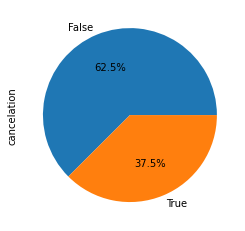

In [9]:
y.loc[X.index].cancelation.value_counts().plot(kind='pie', autopct='%1.1f%%')

It seems that after our initial outlier removal, about two thirds of the samples didn't cancel their order, and about a third did. In the real world we can assume that people don't normally cancel their flights, so we can keep this data despite its imbalance.

Now, let's look at how the different features are correlated with our labels:

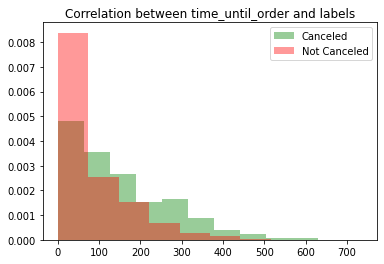

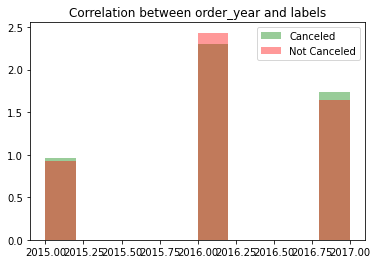

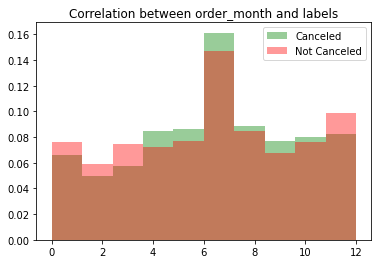

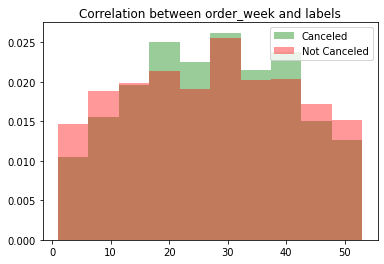

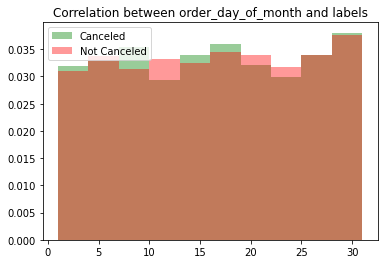

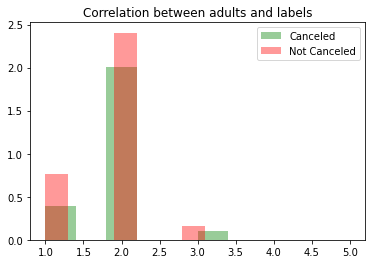

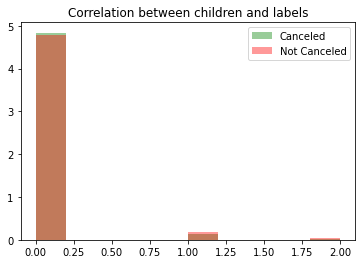

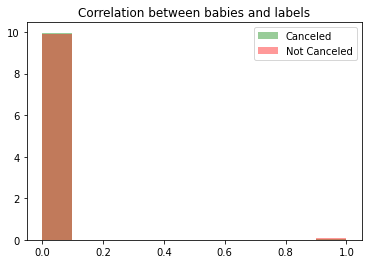

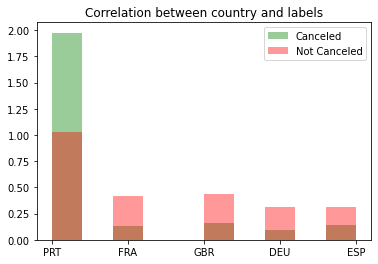

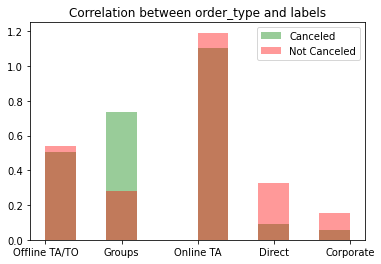

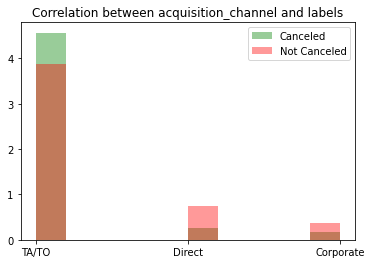

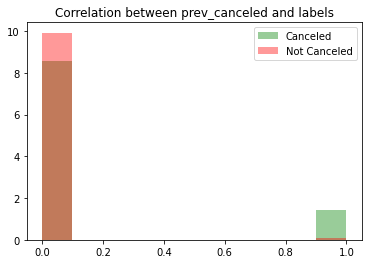

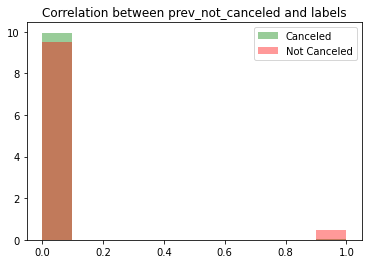

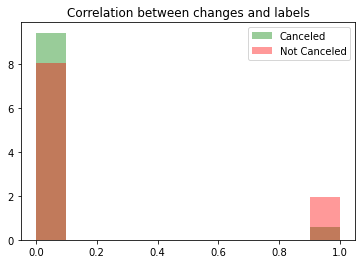

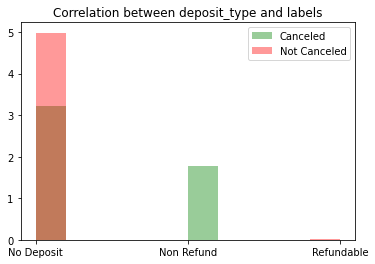

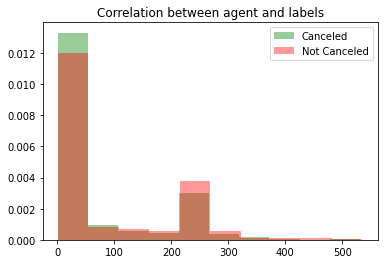

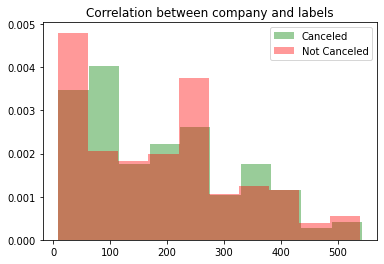

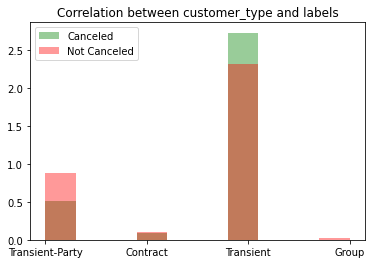

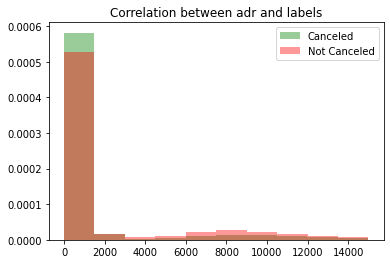

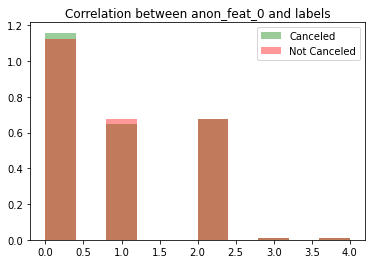

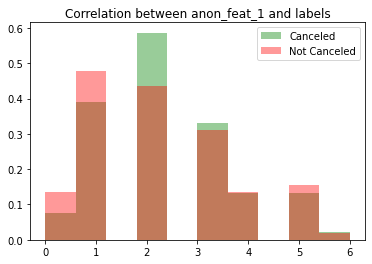

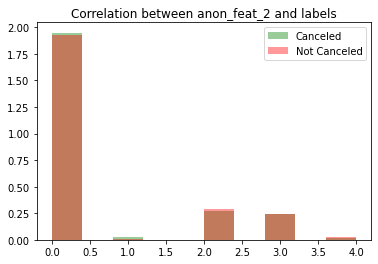

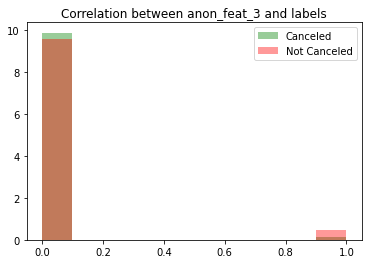

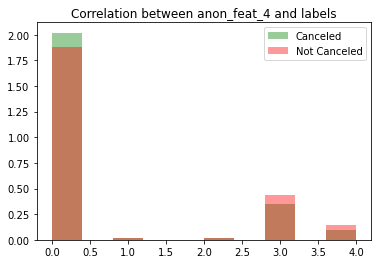

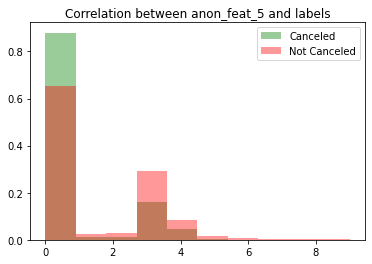

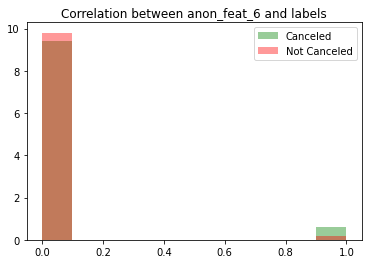

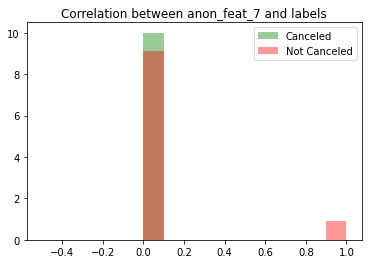

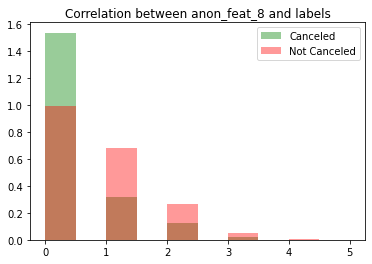

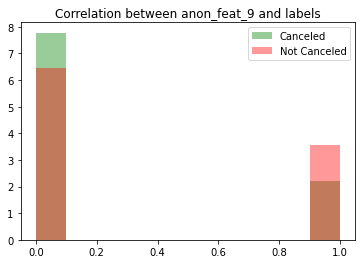

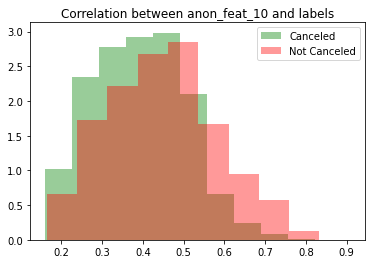

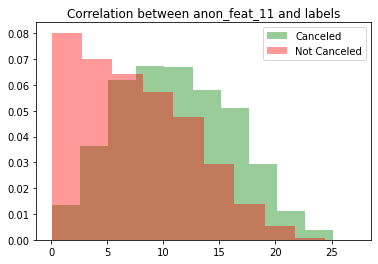

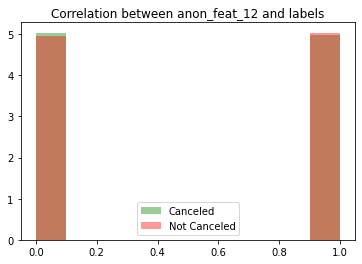

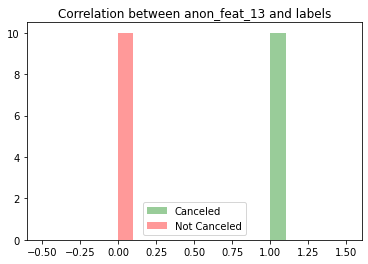

In [10]:
def plot_label_corr(X, col):
    merged_no_outliers = X.merge(y, right_index=True, left_index=True).rename(columns={"cancelation": "label"})
    not_na = ~merged_no_outliers[col].isna()
    positives = merged_no_outliers[col][not_na][merged_no_outliers.label]
    negatives = merged_no_outliers[col][not_na][~merged_no_outliers.label]
    plt.hist(positives, color='g', alpha=0.4, label="Canceled", density=True)
    plt.hist(negatives, color='r', alpha=0.4, label="Not Canceled", density=True)
    plt.legend()
    plt.title(f"Correlation between {col} and labels")
    plt.show()
for col in X.columns:
    plot_label_corr(X, col)

We can see the following facts about the data:
- Orders with time_until_order value below 80 are more likely to not get canceled,
and orders with time_until_order higher than 80 are more likely to get canceled
    We'll convert this variable to a boolean feature with the threshold of 80.
- It seems like more orders are canceled during the spring, summer and fall months (4-11),
and less orders are canceled in the winter months.
    - We'll create a new variable called is_winter
- There seems to be no correlation between children and babies to the label
    - We'll convert both of the to a new feature, is_family.
- It seems as many orders are canceled for Portugal than other countries
    - This means that the dummy variable is_portugal will have more weight than other countries' variables
- Orders with order_type=Groups are more likely to get canceled, and other order_type values are more likely to not get canceled
- It seems like if prev_canceled is 1, it is more likely to be canceled,
whereas if prev_not_canceled is 1 it's highly likely to not get canceled.
- If an order has changed, it's more likely to not get canceled
    - We'll convert it into a boolean field - has_changed
- All Non Refund samples have been canceled!
- All orders with customer_type=group have not been canceled
- If anon_feat_3 is 1 it's more likely to not get canceled
- If anon_feat_4 is 0 it's more likely to get canceled. If it's higher, it's more likely to not get canceled
- If anon_feat_7 is 1 - The order won't get canceled
- If anon_feat_10 is below 0.5 the order is more likely to get canceled,
and if it's higher than it's more likely to not get canceled
- If anon_feat_11 is below 7.5 the order is more likely to not get canceled,
and if it's higher than it's more likely to get canceled
- anon_feat_13 determines exactly if the order will get canceled or not!

### The following features have no correlation with our labels, so we can drop them
- order_year
- agent
- company
- adr
- anon_feat_0
- anon_feat_2
- anon_feat_12

In [11]:
def process_label_correlation(X):
    # Let's drop the columns that have no correlation with the result
    X.drop(columns=["order_year", "agent", "company", "adr",
                    "anon_feat_0", "anon_feat_2", "anon_feat_12"], inplace=True)
    # Let's convert time_until_order to a boolean feature
    X["time_until_order"] = [int(value <= 80) for value in X["time_until_order"]]
    # Let's create is_winter
    X["is_winter"] = [0 if 4 <= value <= 11 else 1 for value in X["order_month"]]

    # Let's create is_family instead of children and babies
    X["is_family"] = X.apply(lambda row: int(row.children > 0 or row.babies > 0), axis=1)
    X.drop(columns=["children", "babies"], inplace=True)

    # Let's create has_changed instead of changes
    X["has_changed"] = [int(value > 0) for value in X.changes]
    X.drop(columns=["changes"], inplace=True)

process_label_correlation(X)


Now, let's see the correlation between the different features

<AxesSubplot:>

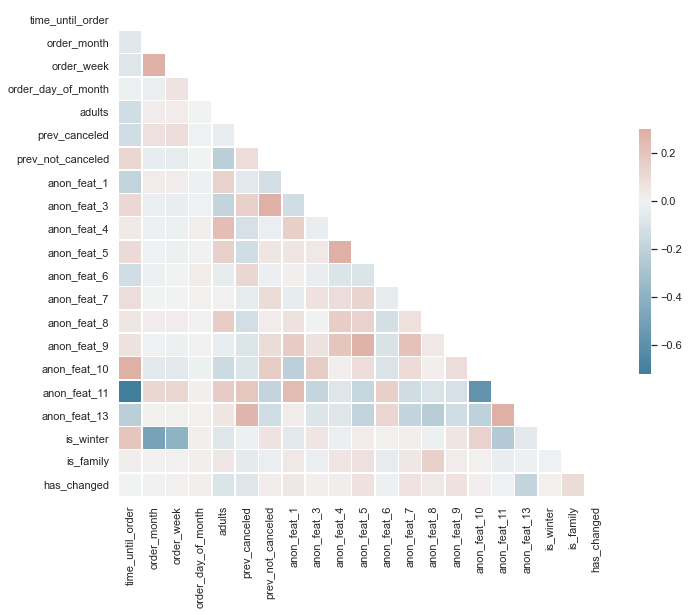

In [12]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            xticklabels=X.corr().columns,
            yticklabels=X.corr().columns)

There's a correlation of 76.16% between prev_not_canceled and anon_feat_3,
and a correlation of 73.31% between anon_feat_4 and anon_feat_5. <br/>
There's also a 90.41% correlation between order_month and order_week.
We'll drop anon_feat_3 (as it's easier to drop an anon feature), anon_feat_4 (because anon_feat_5 has less outliers)
and order_week (because it has a lot more values than order_month)

In [13]:
def process_feature_correlation(X):
    X.drop(columns=["anon_feat_3", "anon_feat_4", "order_week"], inplace=True)

process_feature_correlation(X)

## Part 2: Preprocessing


We already had all of our preprocessing steps in the previous part, so we'll summarize them here:
- Outlier handling - we removed samples based on the following conditions:
    - <code>adults</code> was outside the normal values (1 < adults < 5)
    - <code>children</code> was larger than 2
    - <code>adr</code> was larger than 15,000
    - <code>anon_feat_0</code> was above 5
    - <code>anon_feat_1</code> was above 6
    - <code>anon_feat_4</code> was above 4
    - <code>anon_feat_7</code> was above 1
    - <code>acquisition_channel</code> was either GDS or Undefined
    - <code>deposit_type</code> was Undefined
- Normalize data - we made the following adjustments to normalize our data:
    - Converted <code>babies, prev_canceled, prev_not_canceled, changes, anon_feat_6, time_until_order</code> to boolean features
    - Created new boolean features <code>is_winter, is_family</code> based on existing numerical features
    - In the next section we'll normalize the variables that are normally distributed to make the weights of our model
    smaller and avoid over-fit due to large weights.
- Removed highly correlated features to reduce dimensionality
    - prev_not_canceled and anon_feat_3 were highly correlated, so we removed anon_feat_3 since it's easier to drop anon features
    - anon_feat_4 and anon_feat_5 were highly correlated, so we removed anon_feat_4 since anon_feat_4 had more outliers

#### Let's normalize the variables we know are normally distributed
The variables we assumed are normally distributed are:
- order_month
- anon_feat_10
- anon_feat_11

In [14]:
def normalize_features(X):
    column_transformer = make_column_transformer((StandardScaler(), ["order_month", "anon_feat_10", "anon_feat_11"]))
    data = column_transformer.fit_transform(X)
    X["order_month"] = data[:,0]
    X["anon_feat_10"] = data[:,1]
    X["anon_feat_11"] = data[:,2]

normalize_features(X)

Now let's look at missing values. We don't really care about categorical features having NaN values,
as they'll disappear when we'll create dummy variables.

In [15]:
X.isna().sum() * 100 / X_backup.shape[0]

time_until_order        0.000000
order_month             0.000000
order_day_of_month      0.000000
adults                  0.000000
country                26.718188
order_type              0.685712
acquisition_channel     0.000000
prev_canceled           0.000000
prev_not_canceled       0.000000
deposit_type            9.084005
customer_type           9.957338
anon_feat_1             0.000000
anon_feat_5             4.056197
anon_feat_6             4.267271
anon_feat_7             4.269505
anon_feat_8             0.000000
anon_feat_9             3.739027
anon_feat_10            2.749548
anon_feat_11            5.059078
anon_feat_13           84.427420
is_winter               0.000000
is_family               0.000000
has_changed             0.000000
dtype: float64

We can see that anon_feat_13 has 84.427% missing values. We could drop it but because of its high correlation with our label we'll keep it and just treat it as a categorical variable.<br/>
We need to address the following variables: <code>anon_feat_5, anon_feat_6, anon_feat_7, anon_feat_9, anon_feat_10, anon_feat_11</code> <br/>
After a quick check, we saw that more than 25% of the samples have missing values in one of these features. <br/>
This means that we need to replace them and not drop them.

array([[<AxesSubplot:title={'center':'anon_feat_5'}>,
        <AxesSubplot:title={'center':'anon_feat_6'}>],
       [<AxesSubplot:title={'center':'anon_feat_7'}>,
        <AxesSubplot:title={'center':'anon_feat_9'}>],
       [<AxesSubplot:title={'center':'anon_feat_10'}>,
        <AxesSubplot:title={'center':'anon_feat_11'}>]], dtype=object)

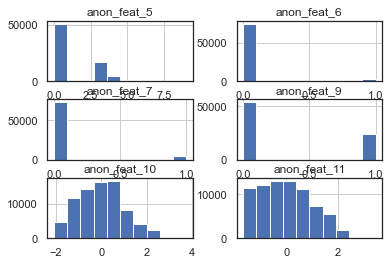

In [16]:
MISSING_VALUES_COLUMNS = ["anon_feat_5", "anon_feat_6", "anon_feat_7", "anon_feat_9", "anon_feat_10", "anon_feat_11"]
X[MISSING_VALUES_COLUMNS].hist()

We'll assume that anon_feat_10 and anon_feat_11 are normally distributed,
as their histogram looks similar to the Gaussian bell. <br/>
As for the rest of the, we'll use K-NN to fill the missing values.

In [17]:
NORMALIZED_COLUMNS = ["anon_feat_10", "anon_feat_11"]
MEANS = X.mean()
ANON_FEAT_13_NORMAL = {0: -1, 1: 1}

def process_missing_values(X, knn_imputer):
    for col in NORMALIZED_COLUMNS:
        X[col].fillna(value=MEANS[col], inplace=True)

    missing_values_columns = [col for col in MISSING_VALUES_COLUMNS if col not in NORMALIZED_COLUMNS]
    transformed_data = knn_imputer.transform(X[missing_values_columns])
    for i in range(len(missing_values_columns)):
        X[missing_values_columns[i]] = transformed_data[:,i]

    X["anon_feat_13"] = X.apply(lambda row: ANON_FEAT_13_NORMAL[row.anon_feat_13]
                                if pd.notna(row.anon_feat_13) else 0, axis=1)

imp_knn = KNNImputer(n_neighbors=50)
missing_values_columns = [col for col in MISSING_VALUES_COLUMNS if col not in NORMALIZED_COLUMNS]
imp_knn.fit(X[missing_values_columns])

process_missing_values(X, imp_knn)

Now we can dummify our categorical features

In [18]:
def dummify(X, cols):
    for col in cols:
        dummies = pd.get_dummies(X[col], prefix=col, dummy_na=False)
        X = X.drop(col, 1)
        X = pd.concat([X, dummies], axis=1)
    return X

X = dummify(X, CATEGORICAL_FEATURES)

After creating dummy variables we're left with 38 features. <br />
One might argue that for a dataset of around 90,000 samples 38 features isn't a lot,
but we'll try reducing the dimensionality of the dataset to try to ignore some of the dummy variables we created.

In [19]:
k_best_selector = SelectKBest(k=25)
k_best_selector.fit(X, y.loc[X.index].cancelation)
mask = k_best_selector.get_support()
kept_features = []
for indicator, feature in zip(mask, X.columns):
    if indicator:
        kept_features.append(feature)

X = X[kept_features]
kept_features

['time_until_order',
 'prev_canceled',
 'prev_not_canceled',
 'anon_feat_5',
 'anon_feat_6',
 'anon_feat_7',
 'anon_feat_8',
 'anon_feat_9',
 'anon_feat_10',
 'anon_feat_11',
 'anon_feat_13',
 'has_changed',
 'country_DEU',
 'country_FRA',
 'country_GBR',
 'country_PRT',
 'order_type_Corporate',
 'order_type_Direct',
 'order_type_Groups',
 'acquisition_channel_Direct',
 'acquisition_channel_TA/TO',
 'deposit_type_No Deposit',
 'deposit_type_Non Refund',
 'customer_type_Transient',
 'customer_type_Transient-Party']

Now let's apply PCA to reduce even more dimensions

In [20]:
pca = PCA(n_components=5, whiten=True)
pca.fit(X, y.loc[X.index])
pca_data = pca.transform(X)
X = pd.DataFrame(data=pca_data, index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.35991769 0.20681144 0.09066123 0.06086843 0.04667408]


Let's summarize all transformations into one function so we can call it to preprocess our test data

In [21]:
def preprocess(X, countries_to_keep, knn_imputer, kept_features=None, pca=None, 
               should_process_outliers=True, should_process_nan=True):
    initial_preprocess(X)
    if should_process_outliers:
        process_outliers(X, countries_to_keep=countries_to_keep)
    
    process_label_correlation(X)
    process_feature_correlation(X)
    normalize_features(X)
    if should_process_nan:
        process_missing_values(X, knn_imputer)
    
    X = dummify(X, CATEGORICAL_FEATURES)
    
    if kept_features:
        X = X[kept_features]
    
    if pca:
        if not should_process_nan:
            raise Exception("Can't perform PCA with missing values")
        
        pca_df = pd.DataFrame(data=pca.transform(X), index=X.index)
        return pca_df
    return X

# Test to make sure we made every preprocessing step in our function
# test_preprocess = X_backup.copy()
# test_preprocess = preprocess(test_preprocess, top_5_countries, imp_knn, kept_features, pca)
# pd.testing.assert_frame_equal(X, test_preprocess)

Let's finish this part by applying the preprocessing to the test data

In [22]:
# X_test = preprocess(X_test, top_5_countries, imp_knn, kept_features, pca, should_process_outliers=False)

## Part 3: Modeling
In this part we'll train four models - Two initial ones and two advanced ones. <br />
The models we chose are:
- Initial models
    - KNN
    - Logistic Regression
- Advanced models
    - Multi-Layer Perceptron (ANN)
    - Random Forest

### K-Nearest Neighbor
Let's use cross-validation to get the best parameter for n_neighbors: <br/>
The method we used was to use GridSearchCV on each value between 10 and 100 with 10 steps. <br/>
This allows us to get a good starting point to then pass to a more specific GridSearchCV to get a better score. <br/>
After running multiple scores it seems that PCA doesn't help with this model's AUC score,
so we'll train it without PCA and just use feature selection based on the features we chose.

In [23]:
X_no_pca = X_backup.copy()
X_no_pca = preprocess(X_no_pca, top_5_countries, imp_knn, kept_features)


The following code block gave this result (saving the execution time): <br/>
<code>{'n_neighbors': 40} 0.8827454070407754</code>

In [24]:
knn_grid_params = {"n_neighbors": np.arange(10, 100, 10)}
knn_clf = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_clf, knn_grid_params, cv=5, scoring="roc_auc")

knn_grid.fit(X, y.loc[X.index].cancelation)
print(knn_grid.best_params_, knn_grid.best_score_)
first_assessment = knn_grid.best_params_["n_neighbors"]

knn_grid_no_pca = GridSearchCV(knn_clf, knn_grid_params, cv=5, scoring="roc_auc")
knn_grid_no_pca.fit(X_no_pca, y.loc[X_no_pca.index].cancelation)
print(knn_grid_no_pca.best_params_, knn_grid_no_pca.best_score_)
first_assessment_no_pca = knn_grid_no_pca.best_params_["n_neighbors"]

{'n_neighbors': 60} 0.8442032292699839
{'n_neighbors': 40} 0.8827454070407754


Now that we have an initial assessment of n_neighbors, let's get a more specific result by using another GridSearchCV.

The following code block gave this result (saving the execution time): <br/>
<code>{'n_neighbors': 46} 0.8828605552356995</code>

In [25]:
# With PCA
knn_grid_params = {"n_neighbors": np.arange(round(first_assessment / 10) * 10 - 9, round(first_assessment / 10) * 10 + 10)}
knn_clf = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_clf, knn_grid_params, cv=5, scoring="roc_auc")
knn_grid.fit(X, y.loc[X.index].cancelation)
print("With PCA: ", knn_grid.best_params_, knn_grid.best_score_)
second_assessment = knn_grid.best_params_

# No PCA
knn_grid_params = {"n_neighbors": np.arange(round(first_assessment_no_pca / 10) * 10 - 9, round(first_assessment_no_pca / 10) * 10 + 10)}
knn_clf = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_clf, knn_grid_params, cv=5, scoring="roc_auc")
knn_grid.fit(X_no_pca, y.loc[X_no_pca.index].cancelation)
print("Without PCA: ", knn_grid.best_params_, knn_grid.best_score_)
second_assessment_no_pca = knn_grid.best_params_

With PCA:  {'n_neighbors': 55} 0.8442940606777759
Without PCA:  {'n_neighbors': 46} 0.8828605552356995


So let's train the model with the best n_neighbors value of <code>46</code>:

In [26]:
# With PCA
knn_clf = KNeighborsClassifier(**second_assessment)
knn_clf.fit(X, y.loc[X.index].cancelation)

# Without PCA
knn_clf_no_pca = KNeighborsClassifier(**second_assessment_no_pca)
knn_clf_no_pca.fit(X_no_pca, y.loc[X_no_pca.index].cancelation)

KNeighborsClassifier(n_neighbors=46)

### Logistic Regression

We'll also use GridSearchCV in this case to determine the best penalty and C values for our model. <br/>
The following code block gave this result (saving the execution time):
<code>Best parameters are: {'C': 0.0018329807108324356, 'penalty': 'l1', 'solver': 'liblinear'}, which provide the score of 0.8071224460214076</code>

In [27]:
lr_grid_params = {'penalty' : ['l1', 'l2'],
                  'C' : np.logspace(-4, 4, 20)}

# With PCA
lr_clf = LogisticRegression(solver="liblinear")
lr_grid = GridSearchCV(lr_clf, lr_grid_params, cv=5, scoring="roc_auc")
lr_grid.fit(X, y.loc[X.index].cancelation)
print(f"Best parameters with PCA are: {lr_grid.best_params_}, which provide the score of {lr_grid.best_score_}")

# Without PCA
lr_grid_no_pca = GridSearchCV(lr_clf, lr_grid_params, cv=5, scoring="roc_auc")
lr_grid_no_pca.fit(X_no_pca, y.loc[X_no_pca.index].cancelation)
print(f"Best parameters without PCA are: {lr_grid.best_params_}, which provide the score of {lr_grid.best_score_}")

Best parameters with PCA are: {'C': 0.0018329807108324356, 'penalty': 'l1'}, which provide the score of 0.8115023608512978
Best parameters without PCA are: {'C': 0.0018329807108324356, 'penalty': 'l1'}, which provide the score of 0.8115023608512978


Let's train the model with the best given values:

In [28]:
lr_clf = LogisticRegression(solver="liblinear", **lr_grid.best_params_)
lr_clf.fit(X, y.loc[X.index].cancelation)

lr_clf_no_pca = LogisticRegression(solver="liblinear", **lr_grid_no_pca.best_params_)
lr_clf.fit(X_no_pca, y.loc[X_no_pca.index].cancelation)

LogisticRegression(C=0.0018329807108324356, penalty='l1', solver='liblinear')

### Multi-Layer Perceptron

We shall now train a MLP model, which will compete with the Random Forest over who has the best score.

We'll use GridSearchCV again to determine the best hyper-parameters we can use.

The following code generated this result:

<code>Generated #15 possible combinations for hidden_layer_sizes for X.
Best parameters with PCA are: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (5, 5, 5), 'learning_rate': 'adaptive', 'solver': 'adam'}, which provide the score of 0.8434446832337057
Generated #75 possible combinations for hidden_layer_sizes for X_no_pca. Best parameters without PCA are: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'solver': 'adam'}, which provide the score of 0.9053129095819058</code>

In [29]:
# mlp_params = {
#     "activation": ["tanh", "relu"],
#     "hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
#     "solver": ["adam"],
#     "alpha": [0.0001, 0.05],
#     "learning_rate": ["constant", "adaptive"],
# }

# def generate_hidden_layer_sizes(X):
#     sizes = []
#     for size in range(1, X.shape[1] + 1):
#         sizes.append(size)
#         sizes.append((size, size))
#         sizes.append((size, size, size))
    
#     return sizes

# mlp_params["hidden_layer_sizes"] = generate_hidden_layer_sizes(X)
# print(f"Generated #{len(mlp_params['hidden_layer_sizes'])} possible combinations for hidden_layer_sizes for X.")
# mlp_grid = GridSearchCV(MLPClassifier(), mlp_params, n_jobs=2, scoring="roc_auc", cv=5)
# mlp_grid.fit(X, y.loc[X.index].values.ravel())
# print(f"Best parameters with PCA are: {mlp_grid.best_params_}, which provide the score of {mlp_grid.best_score_}")

# mlp_params["hidden_layer_sizes"] = generate_hidden_layer_sizes(X_no_pca)
# print(f"Generated #{len(mlp_params['hidden_layer_sizes'])} possible combinations for hidden_layer_sizes for X_no_pca.")
# mlp_grid_no_pca = GridSearchCV(MLPClassifier(), mlp_params, n_jobs=2, scoring="roc_auc", cv=5)
# mlp_grid_no_pca.fit(X_no_pca, y.loc[X.index].values.ravel())
# print(f"Best parameters without PCA are: {mlp_grid_no_pca.best_params_}, which provide the score of {mlp_grid_no_pca.best_score_}")

# import os
# os.system('say "Yay I\'m done"')

In [30]:
mlp_params = {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (5, 5, 5), 
              'learning_rate': 'adaptive', 'solver': 'adam'}
mlp_params_no_pca = {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (20, 20), 
                     'learning_rate': 'constant', 'solver': 'adam'}

In [31]:
mlp_clf = MLPClassifier(**mlp_params)

mlp_clf.fit(X, y.loc[X.index].cancelation)

mlp_clf_no_pca = MLPClassifier(**mlp_params_no_pca)
mlp_clf_no_pca.fit(X_no_pca, y.loc[X_no_pca.index].cancelation)

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

### Random Forest

Let's use GridSearchCV to determine the best values for our model: <br />
For a Random Forest model, we can enter a larger number of features. So let's preprocess our data without using feature selection and PCA:

In [32]:
preprocessed_rf_df = X_backup.copy()
preprocessed_rf_df = preprocess(preprocessed_rf_df, top_5_countries, imp_knn)

The following code block gave this result (saving the execution time): <br/>
<code>Best parameters are: {'n_estimators': 1320, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 43, 'bootstrap': False}, which provide the score of 0.929099160943565</code>

We used Google Cloud's AI Platform to give us hyper-tuning results for our model.
We first ran a test of the following values:
- n_estimators: Any integer between 200 and 5000
- max_features: Either 'sqrt', 'log2' or 'auto'
- criterion: Either 'gini' or 'entropy'
- max_depth: Any integer between 10 and 110
- min_samples_split: Any integer between 2 and 10
- min_samples_leaf: Any integer between 1 and 5
- bootstrap: Either True or False

We ran 38 tests and got the following results as our top hyper-parameters:
![title](img/hypertuning/rf/train1.png)
<br/>
After that we saw that we can narrow down our results and get closer estimate. So we ran 190 more tests after fine-tuning our hyper-parameters to these possible values:
- n_estimators: Any integer between 1000 and 2500
- max_features: Either 'sqrt', 'log2' or 'auto'
- criterion: Either 'gini' or 'entropy'
- max_depth: Any integer between 10 and 200
- min_samples_split: Any integer between 4 and 10
- min_samples_leaf: Any integer between 1 and 3
- bootstrap: True
We got the following results, from which we picked the top one to use in our project:
![title](img/hypertuning/rf/train2.png)

In [33]:
rf_params = {
    "n_estimators": [200],
    "criterion": ["gini", "entropy"],
    "min_samples_split":  np.arange(2,5),
    "max_depth": [None],
    "max_features": ["sqrt"],
    "bootstrap": [True],
    "oob_score": [True]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, scoring="roc_auc", cv=5)
rf_grid.fit(preprocessed_rf_df, y.loc[preprocessed_rf_df.index].cancelation)
print(f"Best parameters with are: {rf_grid.best_params_}, which provide the score of {rf_grid.best_score_}")

Best parameters with are: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 200, 'oob_score': True}, which provide the score of 0.936710351215049


In [34]:
rf_clf = RandomForestClassifier(**rf_grid.best_params_)

rf_clf.fit(preprocessed_rf_df, y.loc[preprocessed_rf_df.index].cancelation)

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=4, n_estimators=200, oob_score=True)

## Part 4: Evaluation

In [35]:
def evaluate_model(X, y, clf, n_splits=5, shuffle=False):
    # Start a figure
    plt.figure()

    # Initialize K-Fold
    k_fold = KFold(n_splits, shuffle=shuffle)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    cm = np.zeros((2, 2))

    fig, (ax, cm_ax) = plt.subplots(1, 2, figsize=(16,8))
    fig.suptitle(type(clf).__name__)

    for i, (train_idx, validation_idx) in enumerate(k_fold.split(X)):
        # Split into train and validation, based on current fold
        X_train, X_validation = X[train_idx], X[validation_idx]
        y_train, y_validation = y[train_idx], y[validation_idx]

        # Fit model with train data
        clf.fit(X_train, y_train)

        # Predict one of the validation data's entries to test against our model
        prediction_proba = clf.predict_proba(X_validation)[:, 1]
        y_pred = clf.predict(X_validation)
        cm += confusion_matrix(y_validation, y_pred)

        # Set our ROC curve based on our validation data and prediction of the current fold
        fpr, tpr, threshold = roc_curve(y_validation, prediction_proba)

        # Interpolate the mean_tpr so all classifiers will work under the same thresholds
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        ax.plot(fpr, tpr, alpha=0.3, lw=1, label=f"ROC fold {i}")

    # Divide mean_tpr by number of iterations
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Now we plot the random-guess line
    ax.plot([0, 1], [0, 1], color="navy", linestyle="--")

    # Now we'll plot the mean ROC
    ax.plot(mean_fpr, mean_tpr, color="red", linestyle="-", label=f"Mean ROC (area = {mean_auc})")

    # Some plot boundries and settings
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    # Plot the confusion matrix
    ConfusionMatrixDisplay(cm).plot(ax=cm_ax, values_format='g')
    plt.show()

<Figure size 432x288 with 0 Axes>

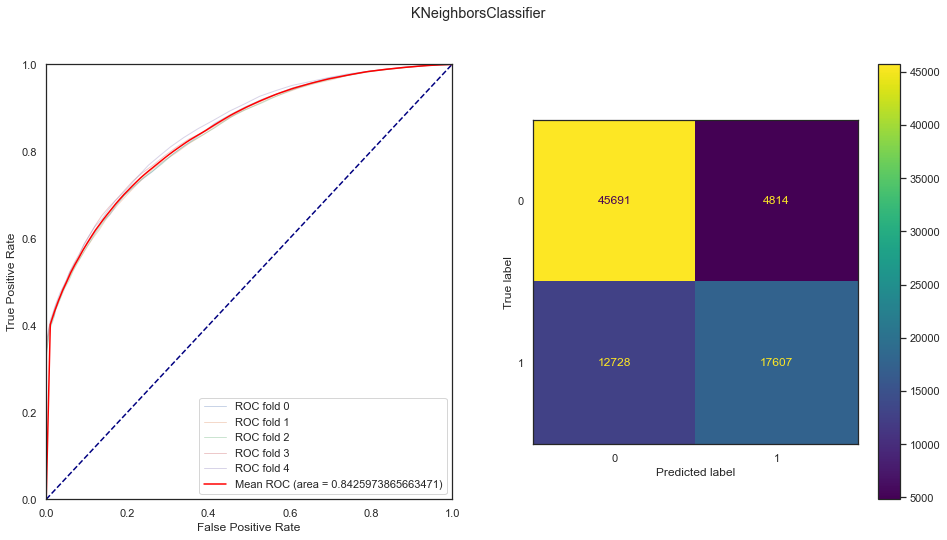

<Figure size 432x288 with 0 Axes>

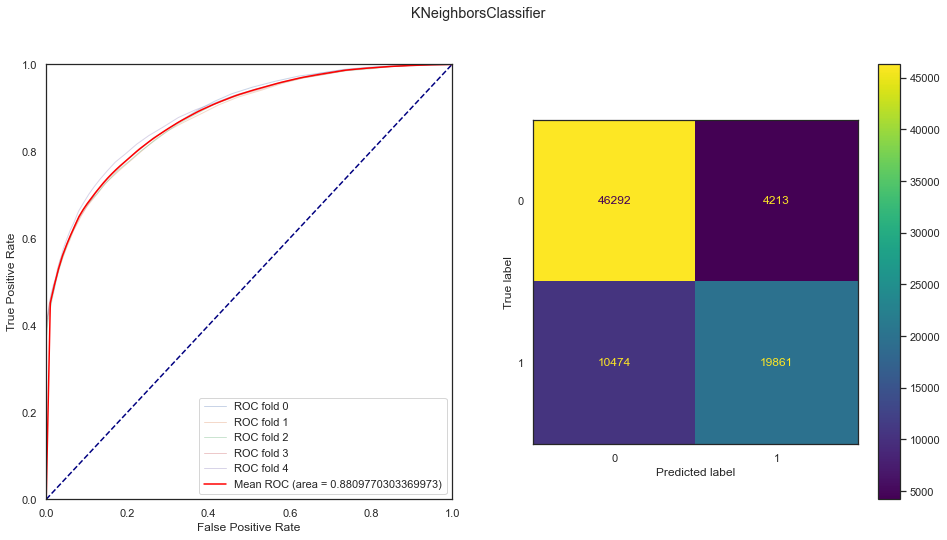

<Figure size 432x288 with 0 Axes>

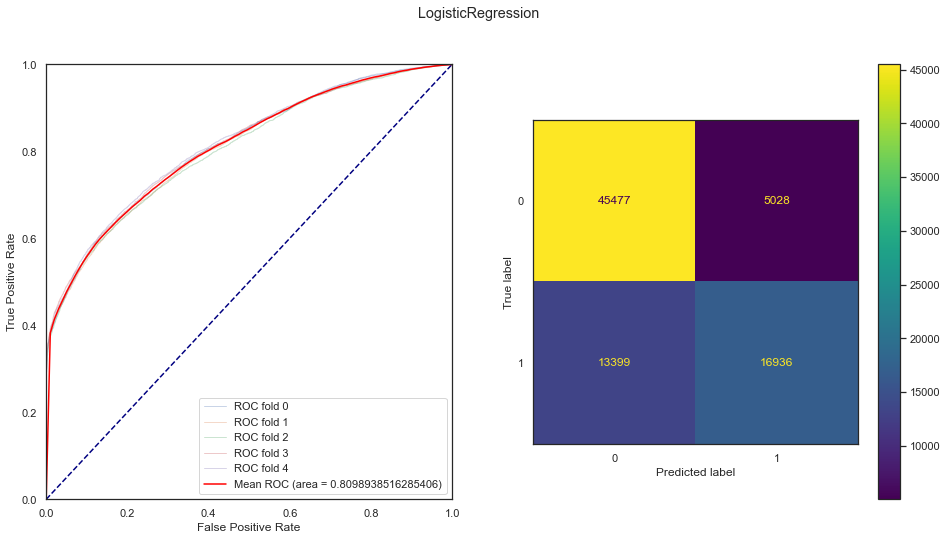

<Figure size 432x288 with 0 Axes>

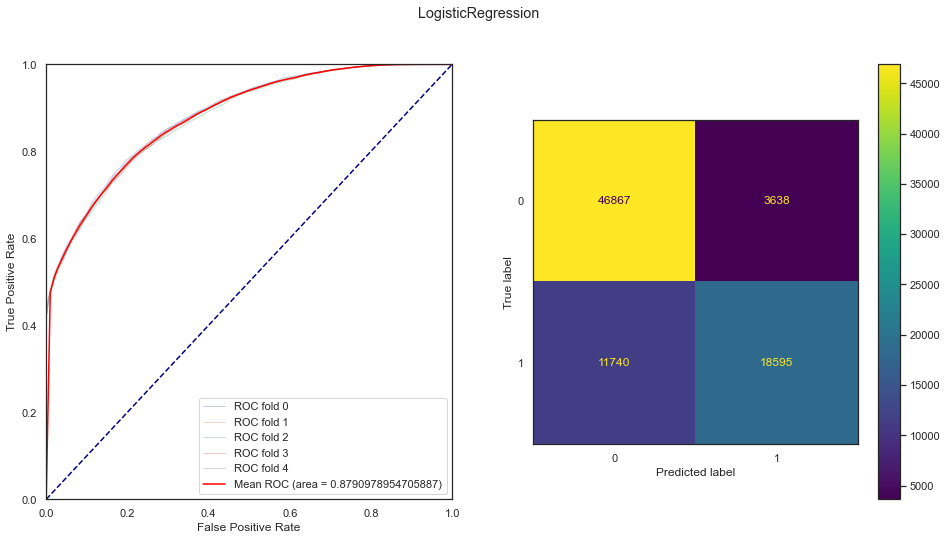

<Figure size 432x288 with 0 Axes>

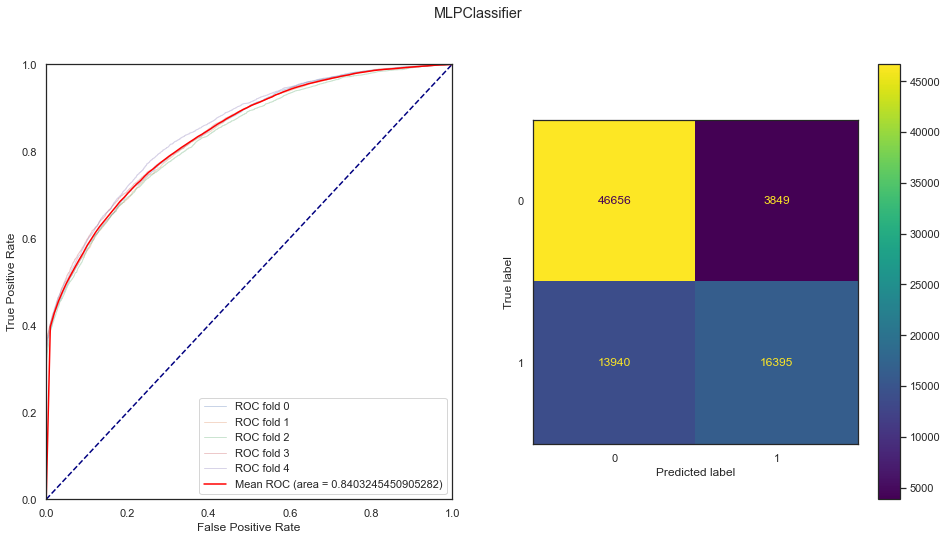

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

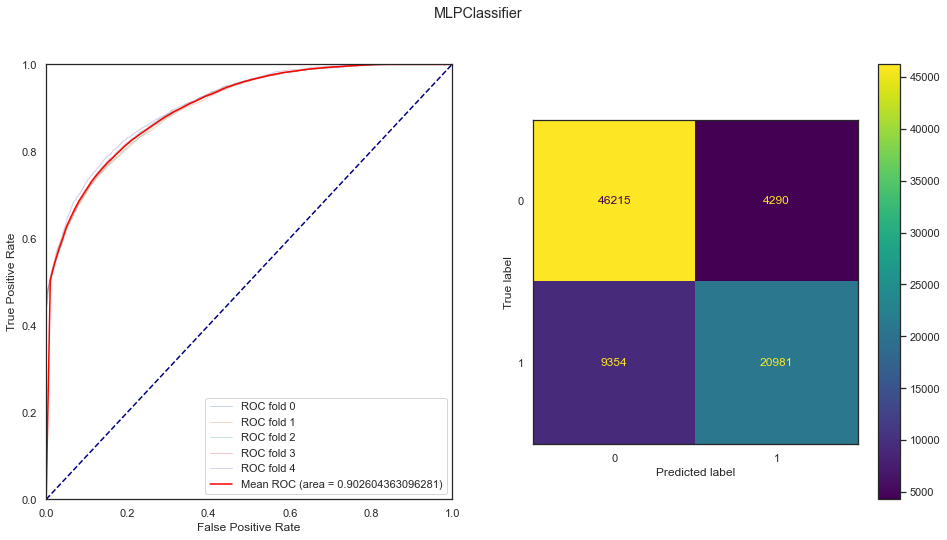

<Figure size 432x288 with 0 Axes>

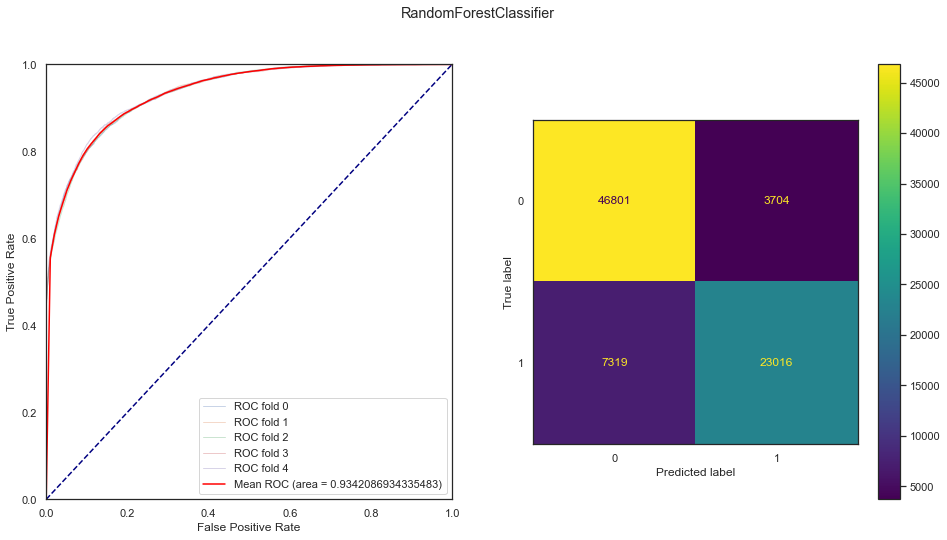

In [36]:
models = [
    (knn_clf, X.values, y.loc[X.index].values.ravel()),
    (knn_clf_no_pca, X_no_pca.values, y.loc[X_no_pca.index].values.ravel()),
    (lr_clf, X.values, y.loc[X.index].values.ravel()),
    (lr_clf_no_pca, X_no_pca.values, y.loc[X_no_pca.index].values.ravel()),
    (mlp_clf, X.values, y.loc[X.index].values.ravel()),
    (mlp_clf_no_pca, X_no_pca.values, y.loc[X_no_pca.index].values.ravel()),
    (rf_clf, preprocessed_rf_df.values, y.loc[preprocessed_rf_df.index].values.ravel())
]
for model, X_train, y_train in models:
    evaluate_model(X_train, y_train, model)

### Confusion Matrix
Each confusion matrix shows how the data was classified opposed to the actual labels:
- In the top left corner we see the True Negative values
    - This data was predicted as "False" (i.e not canceled) and was actually labeled "False"
- In the top right corner we see the False Positive values
    - This data was predicted as "True" (i.e canceled) but was actually labeled "False"
- In the bottom left corner we see the False Negative values
    - This data was predicted as "False" (i.e not canceled) but was actually labeled "True"
- In the bottom right corner we see the True Positive values
    - This data was predicted as "True" (i.e canceled) and was actually labeled "True"

### Overfitting
Explain Here

In [37]:
print(f"Took {(time.time() - start) / 60} mins from start to finish")
import os
os.system('say "Yay I\'m done"')

Took 65.68540854851405 mins from start to finish


0